In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Exploratory Data Analysis

In [2]:
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'figure.autolayout': True
})

In [5]:
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    
    df[['Deck', 'Cabin_num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    
    df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    df['GroupSize'] = df.groupby('Group')['Group'].transform('count')
    
    spending_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpending'] = df[spending_feats].sum(axis=1)
    
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype == 'bool':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
            
    return df

df = load_and_preprocess('train.csv')

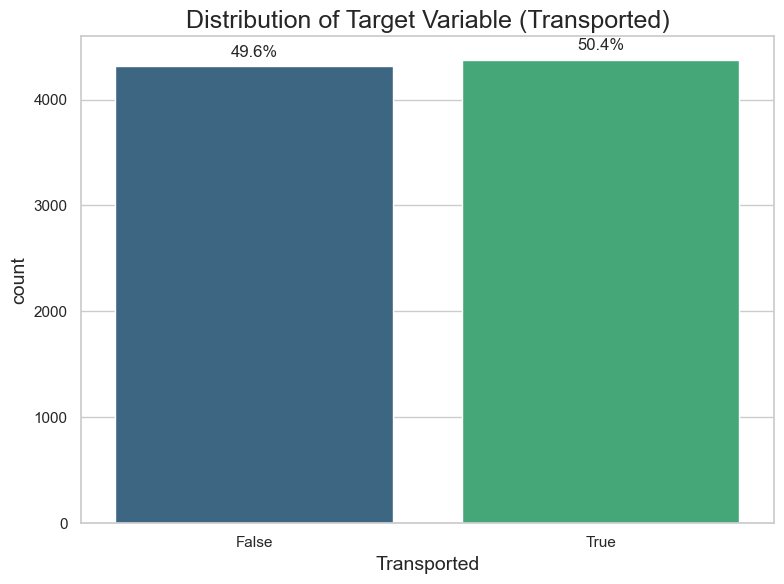

In [6]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Transported', palette='viridis')
plt.title('Distribution of Target Variable (Transported)')
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

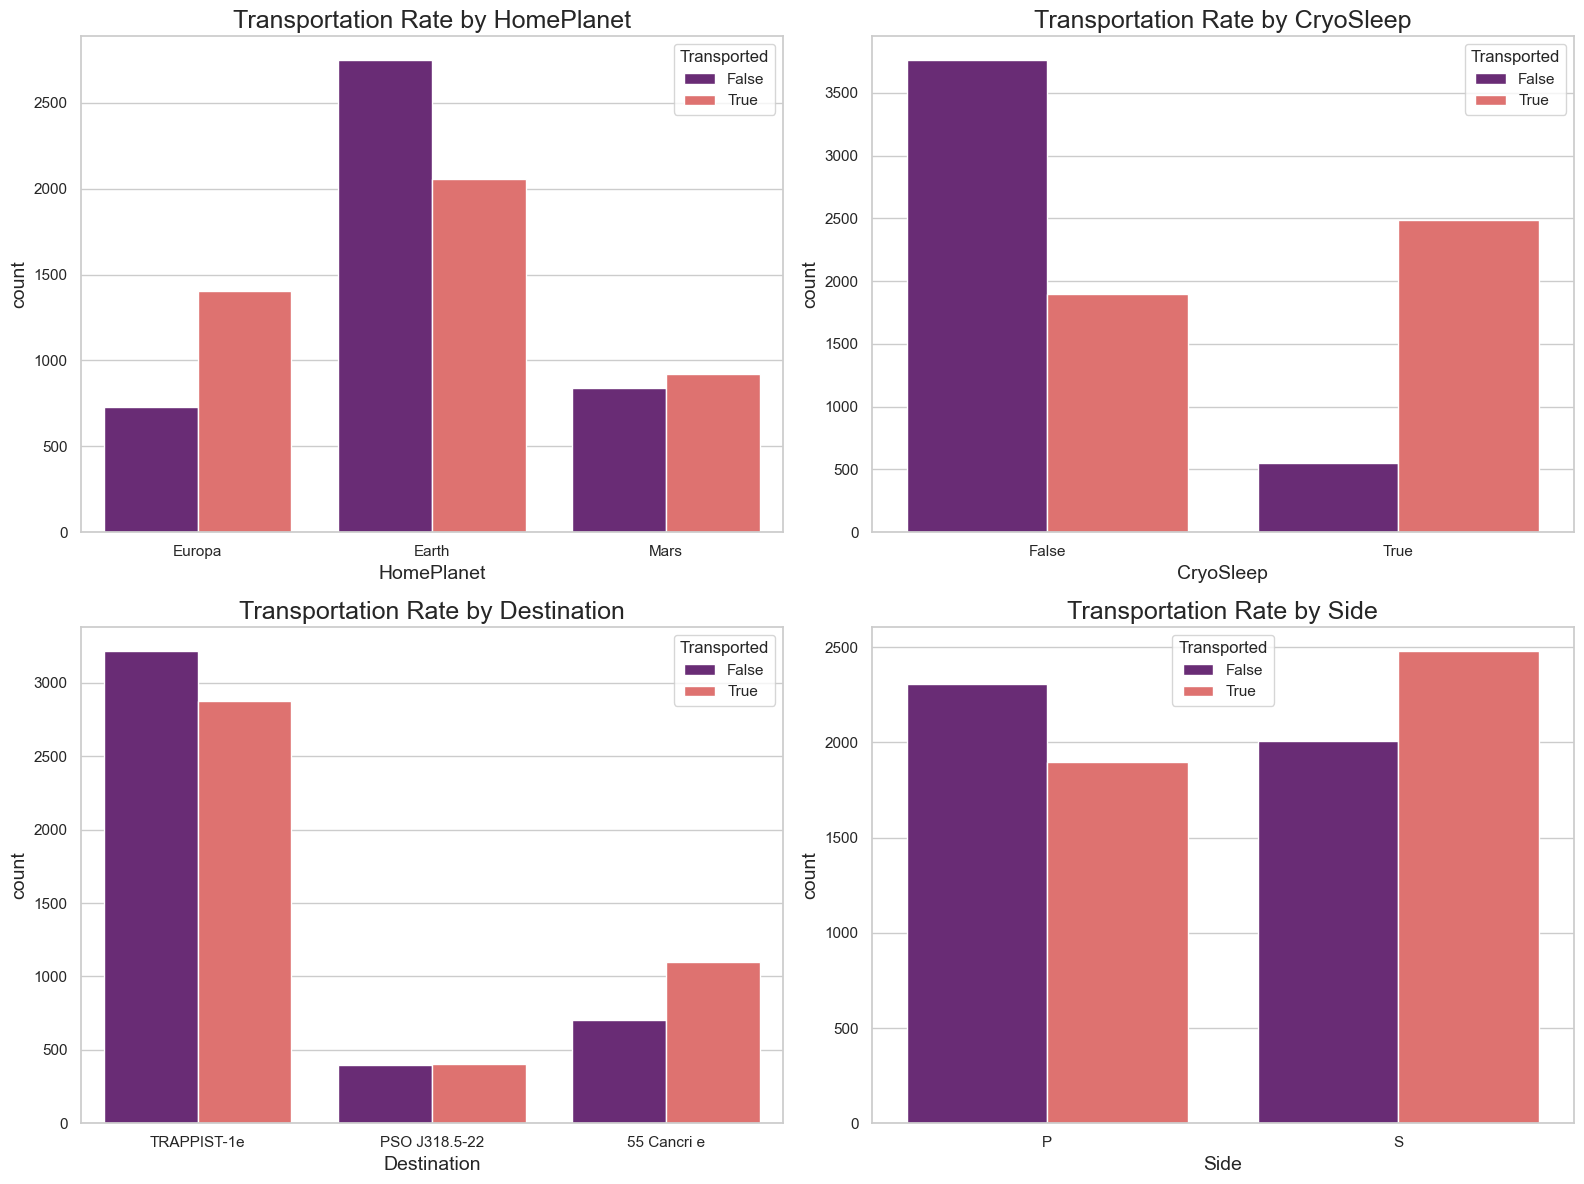

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'Side']
for i, feat in enumerate(cat_features):
    sns.countplot(data=df, x=feat, hue='Transported', ax=axes[i//2, i%2], palette='magma')
    axes[i//2, i%2].set_title(f'Transportation Rate by {feat}')

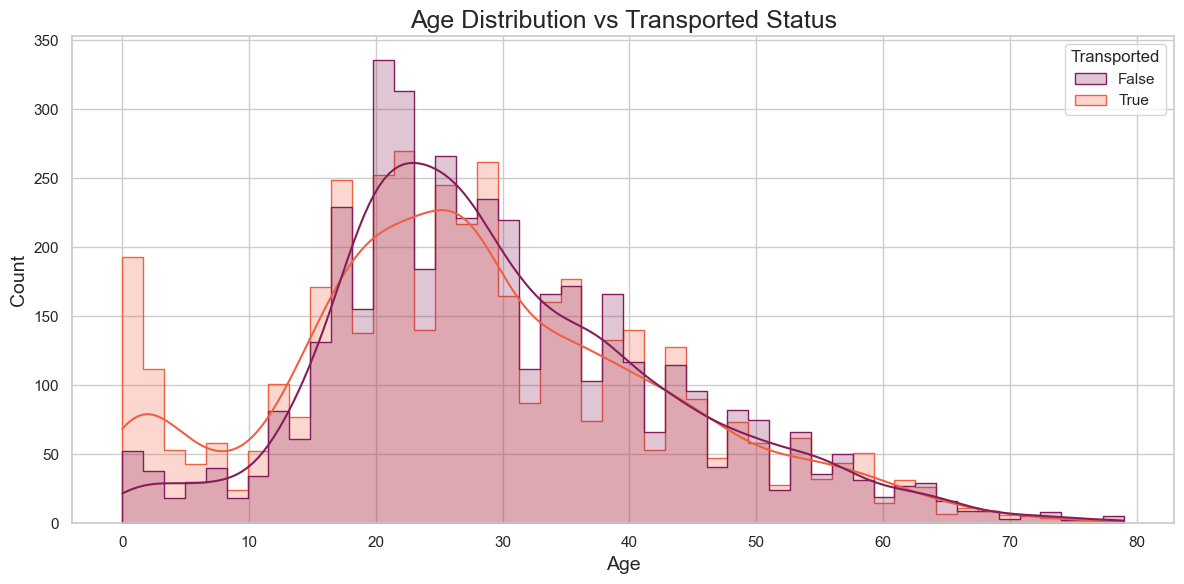

In [8]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age', hue='Transported', kde=True, element="step", palette='rocket')
plt.title('Age Distribution vs Transported Status')

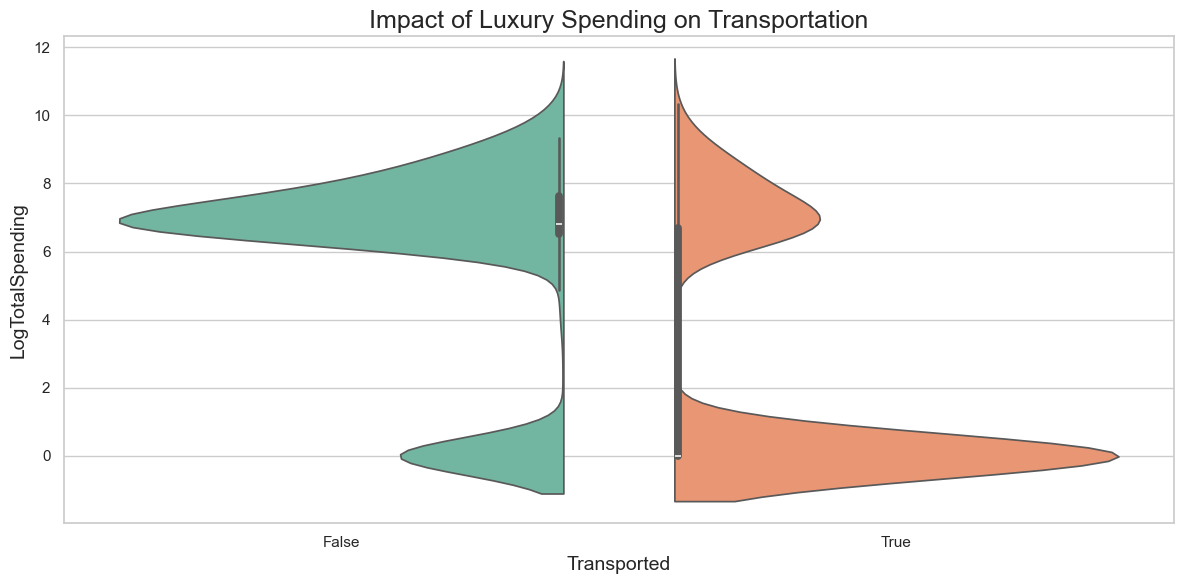

In [9]:
plt.figure(figsize=(12, 6))
df['LogTotalSpending'] = np.log1p(df['TotalSpending'])
sns.violinplot(data=df, x='Transported', y='LogTotalSpending', palette='Set2', split=True)
plt.title('Impact of Luxury Spending on Transportation')

Text(0.5, 1.0, 'Feature Correlation Matrix')

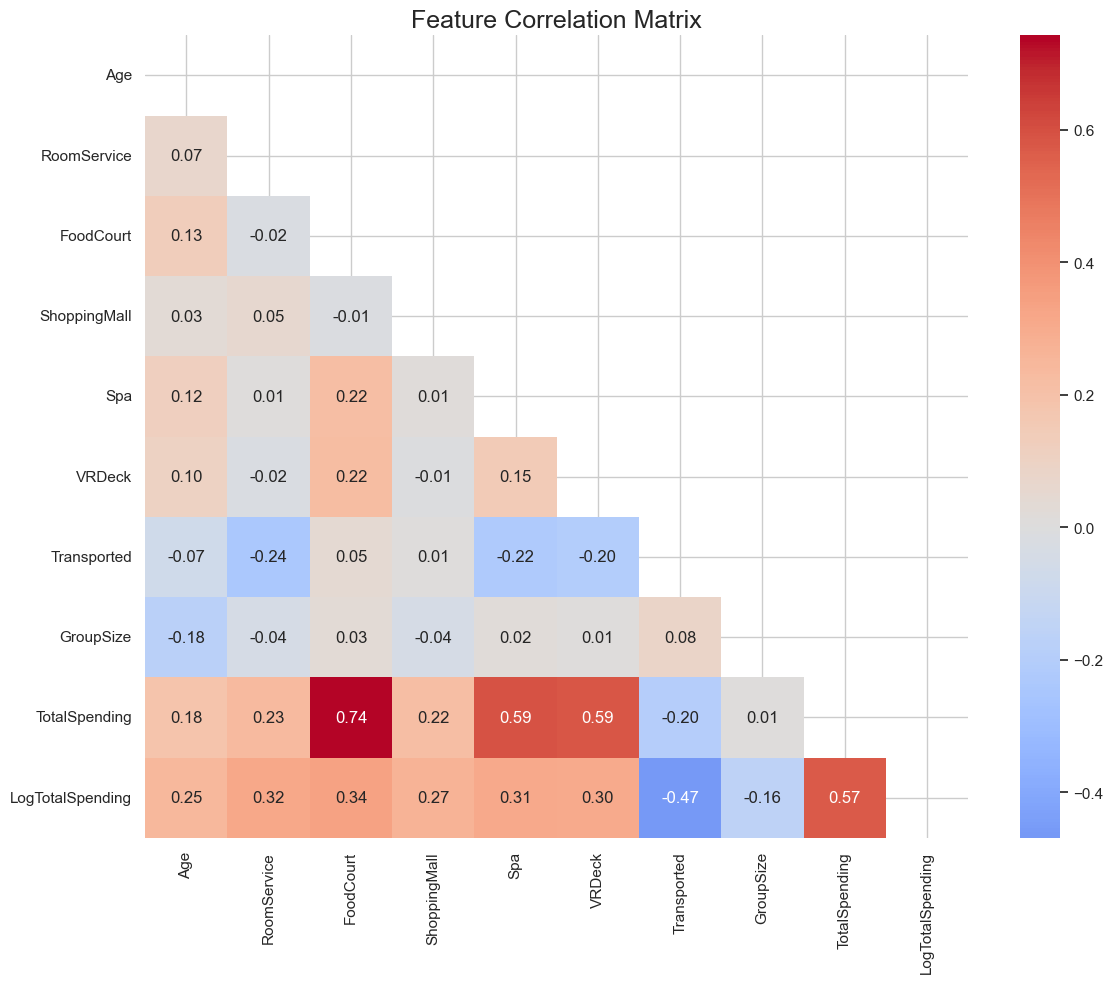

In [10]:
plt.figure(figsize=(12, 10))
df_corr = df.copy()
df_corr['Transported'] = df_corr['Transported'].astype(int)
corr = df_corr.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # Masking upper triangle
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Feature Correlation Matrix')

# Model Training

## Data Preprocessing

In [29]:
warnings.filterwarnings('ignore')
SEED = 42

In [24]:
def clean_data(df):
    """Simple feature engineering and cleaning."""
    data = df.copy()
    
    data[['Deck', 'Num', 'Side']] = data['Cabin'].str.split('/', expand=True)
    data['Num'] = pd.to_numeric(data['Num'], errors='coerce').fillna(0).astype(int)
    
    data['HomePlanet'] = data['HomePlanet'].fillna(data['HomePlanet'].mode()[0])
    data['CryoSleep'] = data['CryoSleep'].fillna(False)
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['VIP'] = data['VIP'].fillna(False)
    data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)
    
    data['TotalSpend'] = data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    
    ids = data['PassengerId']
    data = data.drop(['PassengerId', 'Cabin', 'Name'], axis=1)
    
    data = pd.get_dummies(data)
    return data, ids

In [25]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

In [26]:
X = train_raw.drop('Transported', axis=1)
y = train_raw['Transported'].astype(int)
X_processed, _ = clean_data(X)

In [27]:
X_test, test_ids = clean_data(test_raw)
X_test = X_test.reindex(columns=X_processed.columns, fill_value=0)

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

## Logistic Regression

In [31]:
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=1000))])
lr_params = {'lr__C': [0.1, 1, 10]}
lr_grid = GridSearchCV(lr_pipe, lr_params, cv=cv, scoring='accuracy')
lr_grid.fit(X_processed, y)

model_performance.append({'Model': 'Logistic Regression', 'Score': lr_grid.best_score_, 'Params': lr_grid.best_params_})
lr_preds = lr_grid.predict(X_test)
pd.DataFrame({'PassengerId': test_ids, 'Transported': lr_preds.astype(bool)}).to_csv('logreg_submission.csv', index=False)

### Accuracy: 0.79144

## Support Vector Classification

In [32]:
svc_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))])
svc_params = {'svc__C': [1, 10]}
svc_grid = GridSearchCV(svc_pipe, svc_params, cv=cv, scoring='accuracy')
svc_grid.fit(X_processed, y)

model_performance.append({'Model': 'SVC', 'Score': svc_grid.best_score_, 'Params': svc_grid.best_params_})
svc_preds = svc_grid.predict(X_test)
pd.DataFrame({'PassengerId': test_ids, 'Transported': svc_preds.astype(bool)}).to_csv('svc_submission.csv', index=False)

### Accuracy: 0.80149

## KNN

In [37]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_params = {'knn__n_neighbors': [5, 10, 15, 20]}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=cv)
knn_grid.fit(X_processed, y)

model_performance.append({'Model': 'KNN', 'Score': knn_grid.best_score_})
pd.DataFrame({'PassengerId': test_ids, 'Transported': knn_grid.predict(X_test).astype(bool)}).to_csv('knn_submission.csv', index=False)

### Accuracy: 0.77180

## Random Forest

In [33]:
rf = RandomForestClassifier(random_state=SEED)
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, None]}
rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring='accuracy')
rf_grid.fit(X_processed, y)

model_performance.append({'Model': 'Random Forest', 'Score': rf_grid.best_score_, 'Params': rf_grid.best_params_})
rf_preds = rf_grid.predict(X_test)
pd.DataFrame({'PassengerId': test_ids, 'Transported': rf_preds.astype(bool)}).to_csv('ranfor_submission.csv', index=False)

### Accuracy: 0.79845

## XGBoost Classifier

In [34]:
xgb = XGBClassifier(random_state=SEED, eval_metric='logloss')
xgb_params = {'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=cv, scoring='accuracy')
xgb_grid.fit(X_processed, y)

model_performance.append({'Model': 'XGBoost', 'Score': xgb_grid.best_score_, 'Params': xgb_grid.best_params_})
xgb_preds = xgb_grid.predict(X_test)
pd.DataFrame({'PassengerId': test_ids, 'Transported': xgb_preds.astype(bool)}).to_csv('xgb_submission.csv', index=False)

### Accuracy: 0.80523

## Ensemble Model ( Soft Voting )

In [39]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_grid.best_estimator_),
        ('knn', knn_grid.best_estimator_), 
        ('svc', svc_grid.best_estimator_),
        ('rf', rf_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_)
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(train_X, train_y)

final_predictions = voting_clf.predict(test_X)

In [40]:
submission = pd.DataFrame({
    "PassengerId": test_ids,
    "Transported": final_predictions.astype(bool)
})
submission.to_csv("voting_submission.csv", index=False)

### Accuracy: 0.79261